# **Object Motion Tracking through Change Detection and Connected Components Analysis**

##### ***Task***

<u>**LAB - "Motion"**:</u> Starting from the change detection notebook, extend the analysis over time: given a binary map obtained at time t, compute the connected components (see for instance https://scipy-lectures.org/intro/scipy/auto_examples/plot_connect_measurements.html?highlight=connected%20components), compute the centroid of each image, and relate connected components of adjacent frames for instance by evaluating their vicinity on the image plane. if you carry on the analysis from the first frame to the last, you will obtain a trajectory of each object (you may apply Kalman filtering to deal with noise, occlusions, ...). Present an analysis and an appropriate visualization on the trajectories distributions on the image plane. You may use data provided with the original lab or find new ones

##### **Introduction**

In this extended activity, we analyze object motion over time using a sequence of image frames. The goal is to compute and visualize object trajectories on the image plane.

Given a set of binary change maps derived from frame differencing, we:

- extract connected components from each binary map,

- compute the centroid of each detected object,

- link centroids across consecutive frames based on spatial proximity to reconstruct trajectories, visualizing these connections with arrows to clearly show object movement,

- apply a Kalman filter to improve robustness against noise and occlusions.

We use a pre-ordered sequence of image frames instead of a video. This allows for flexible preprocessing and easier debugging. In the final step, we present a visualization of the trajectories over the image space and provide insights on motion patterns.

In [1]:
import os
import zipfile
import urllib.request
from skimage import io, color
from skimage.color import label2rgb
import numpy as np
from scipy.ndimage import label, center_of_mass
import matplotlib.pyplot as plt

In [2]:
# --- Download ZIP from GitHub ---
zip_url = 'https://github.com/justwsx/CVProject/raw/main/frames.zip'
zip_path = 'frames.zip'

if not os.path.exists(zip_path):
    print("Downloading frames.zip from GitHub...")
    urllib.request.urlretrieve(zip_url, zip_path)
    print("Download completed!")
else:
    print("frames.zip already present.")

# --- Extract ZIP ---
frame_folder = 'frames'
if not os.path.exists(frame_folder):
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete!")
else:
    print(f"Folder '{frame_folder}' already exists.")

# --- Load frames ---
frame_files = sorted(os.listdir(frame_folder))
frames = []
for filename in frame_files:
    img = io.imread(os.path.join(frame_folder, filename))
    gray = color.rgb2gray(img)
    frames.append(gray)

print(f"Loaded {len(frames)} frames.")

Download completed!
Extracting frames.zip ...
Extraction complete!
Loaded 71 frames.


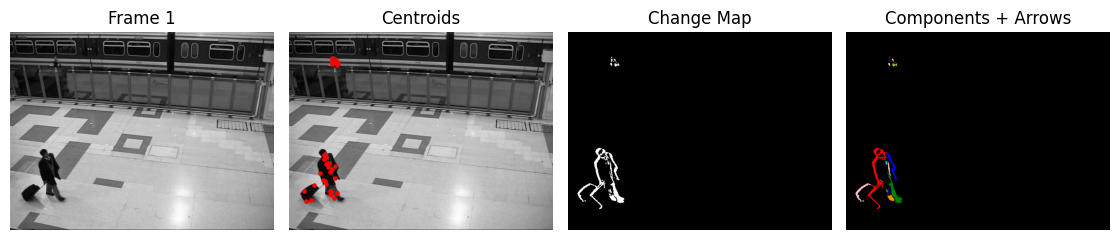

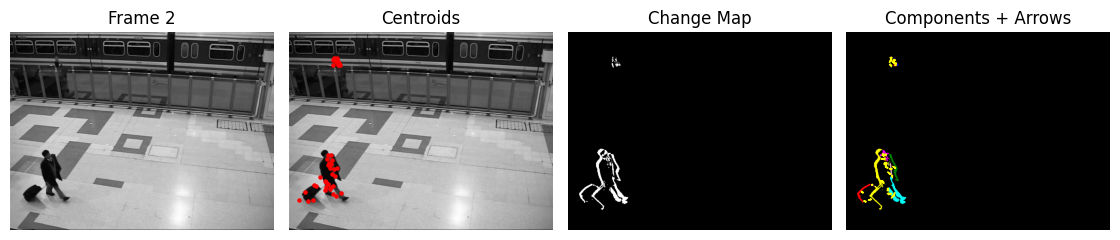

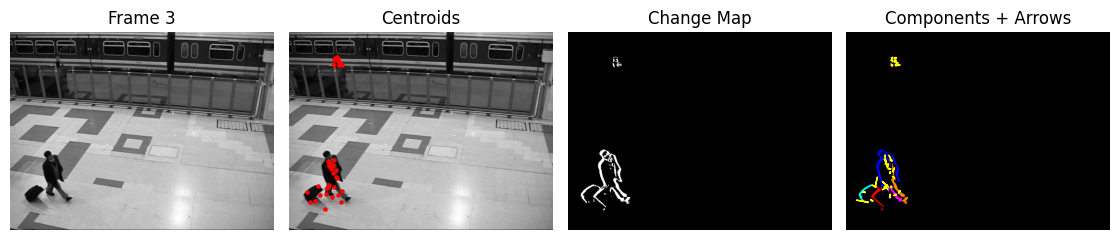

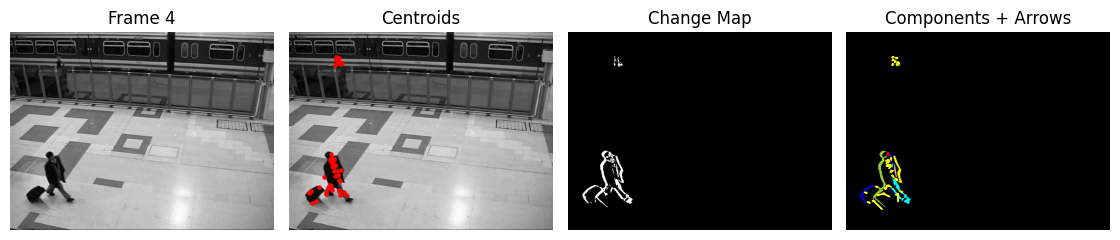

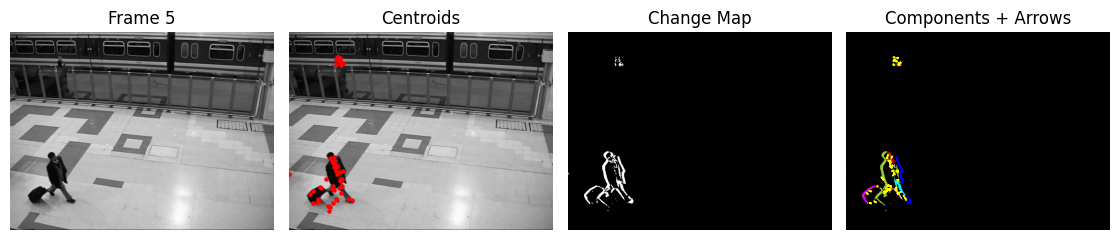

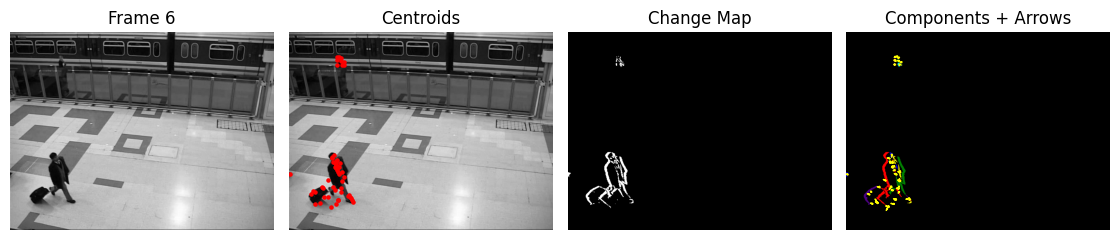

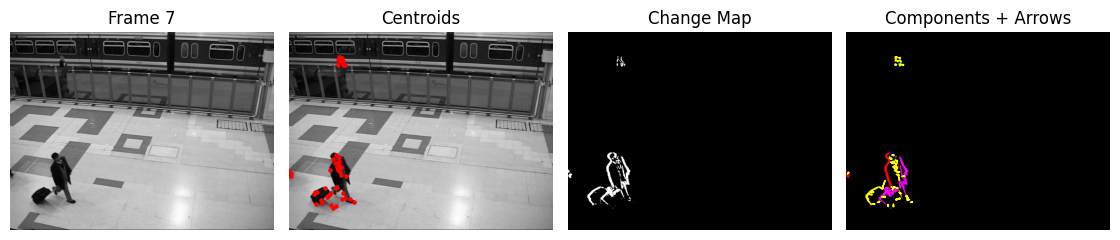

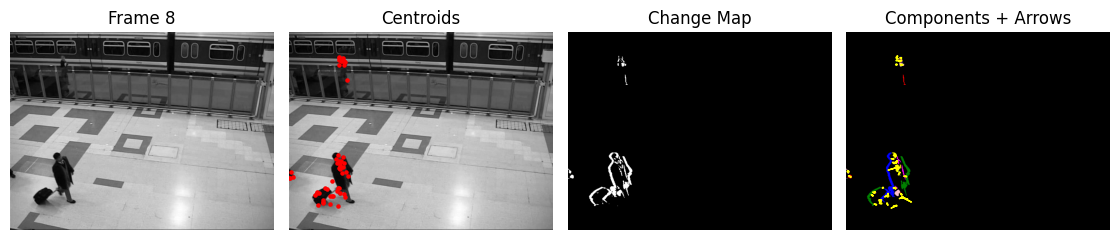

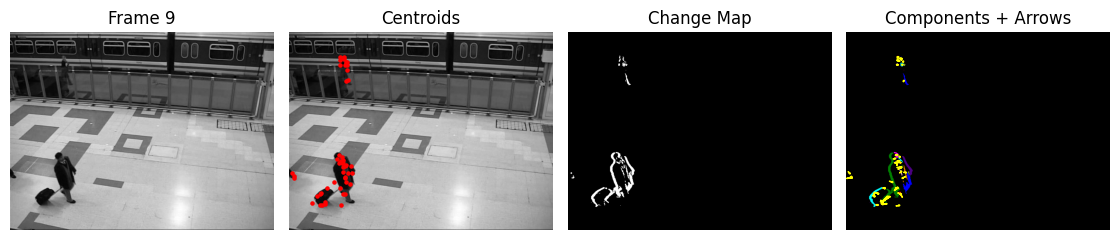

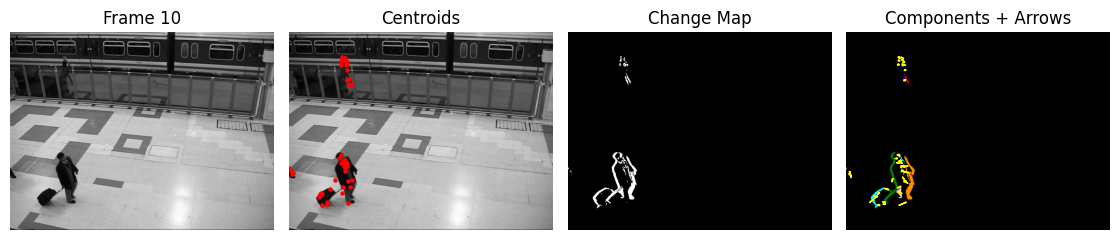

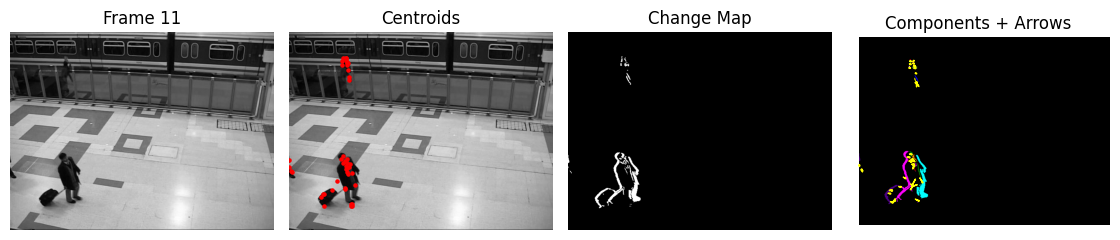

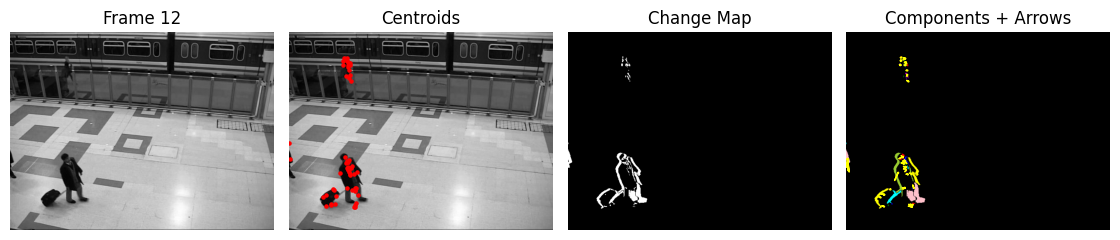

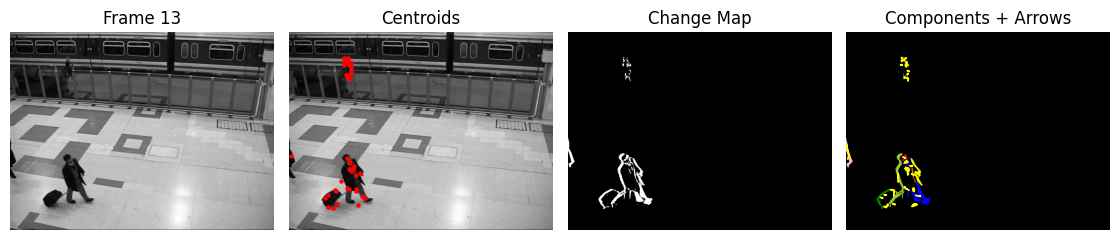

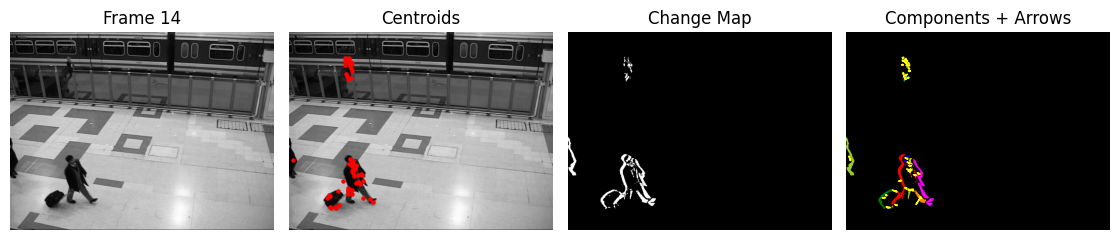

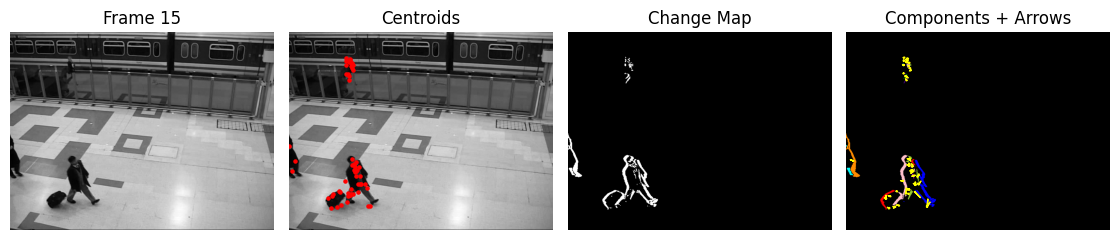

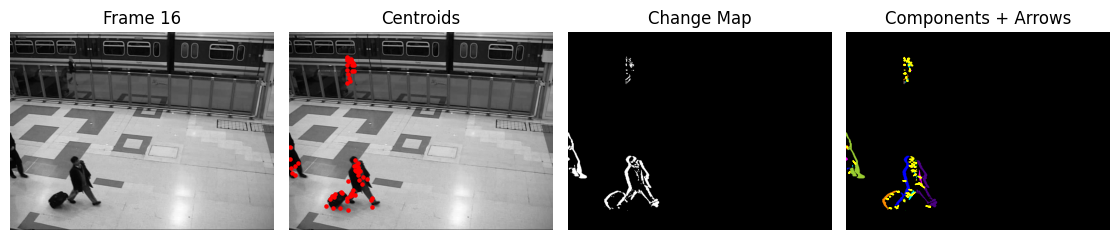

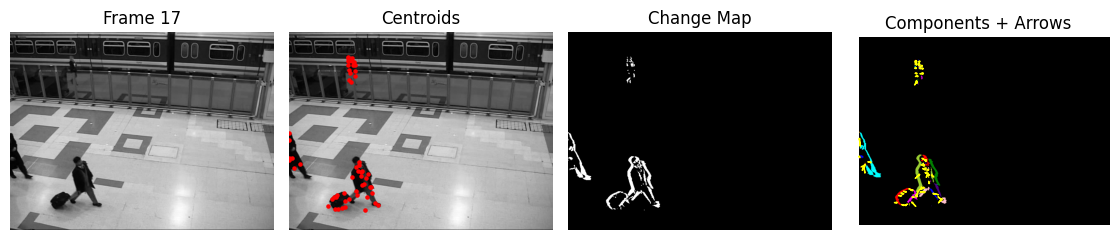

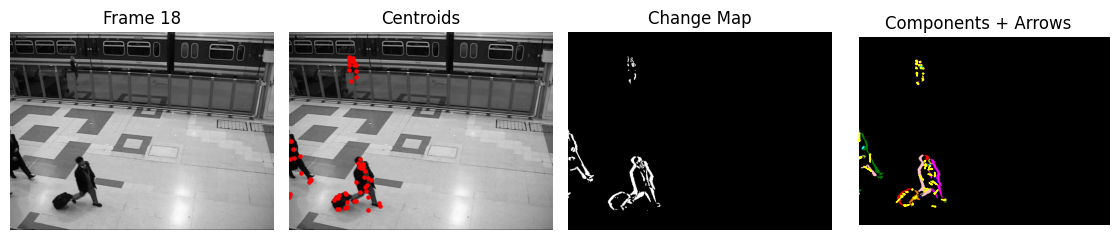

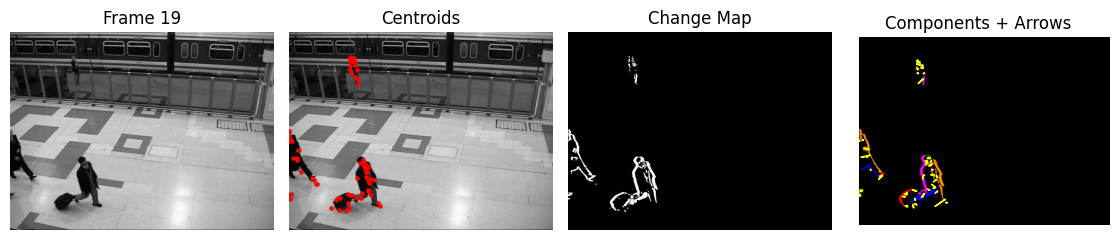

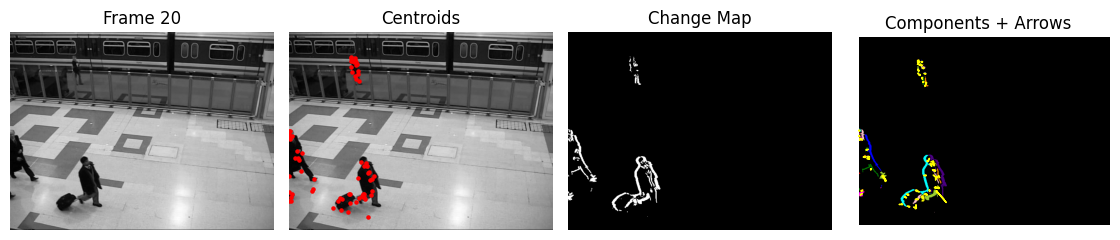

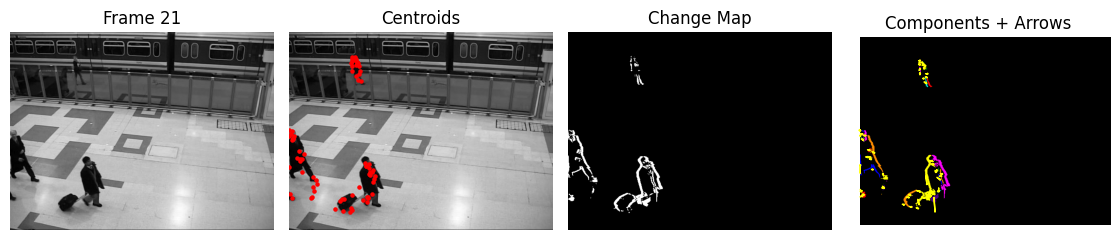

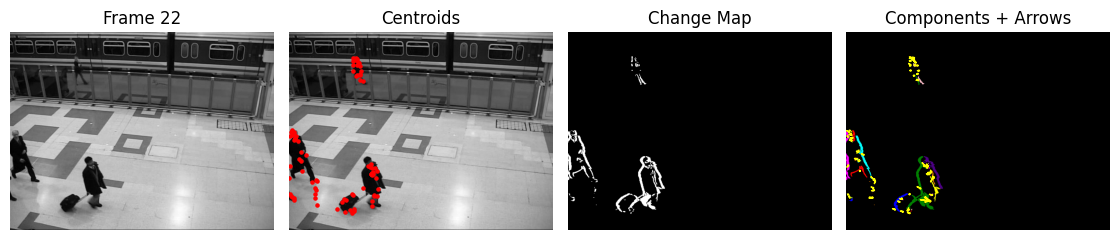

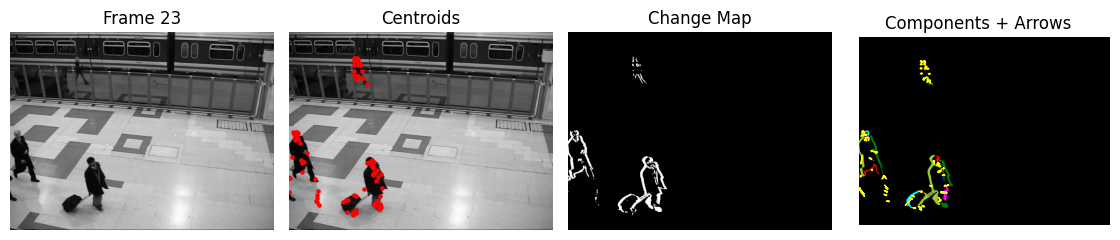

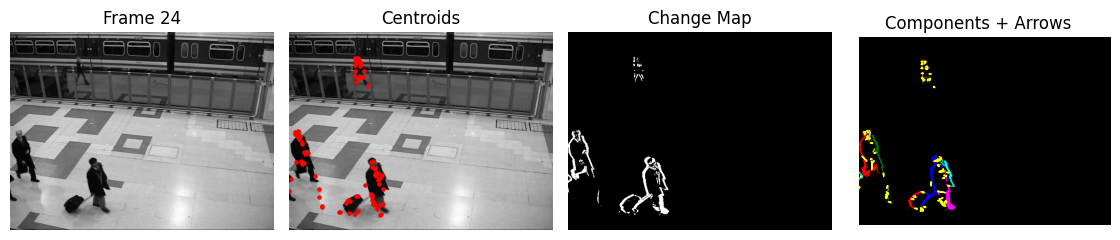

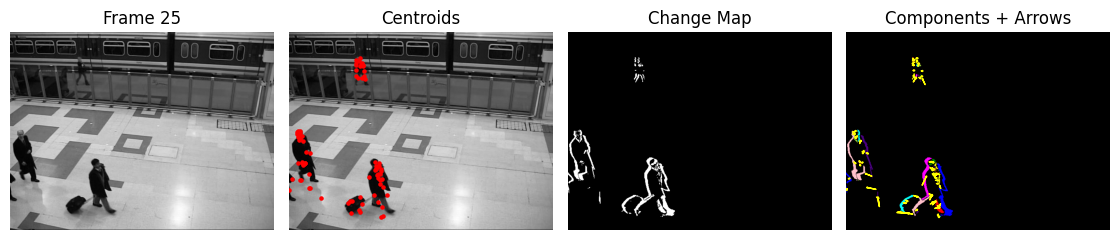

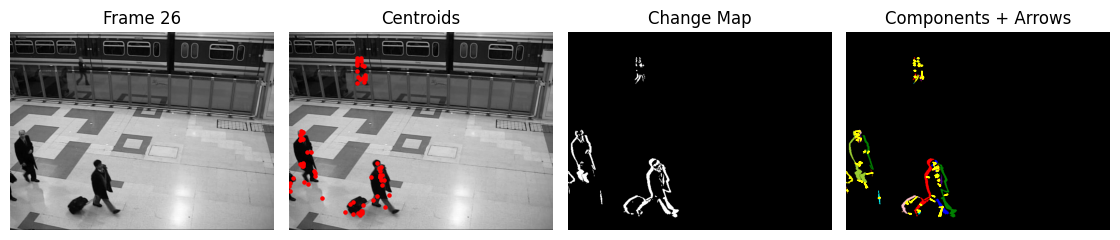

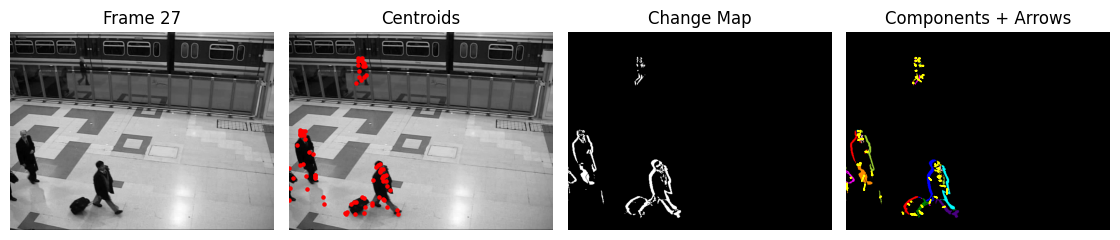

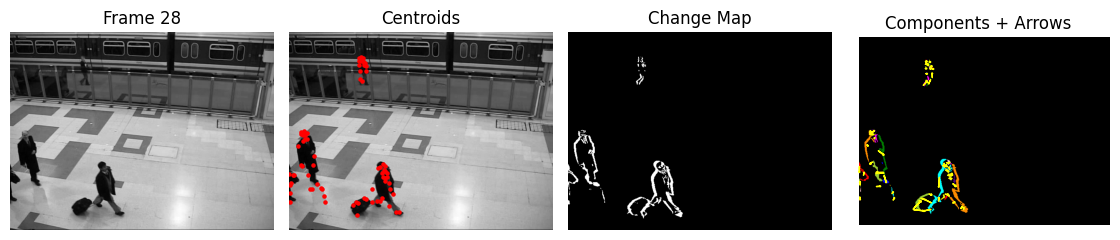

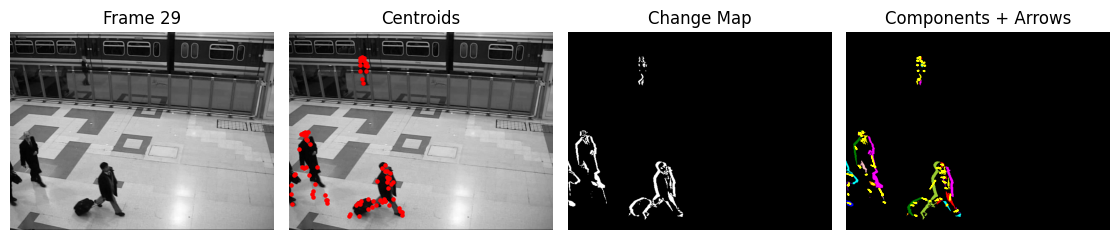

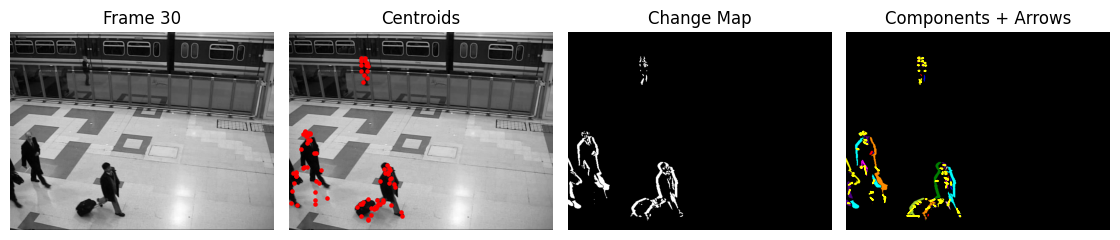

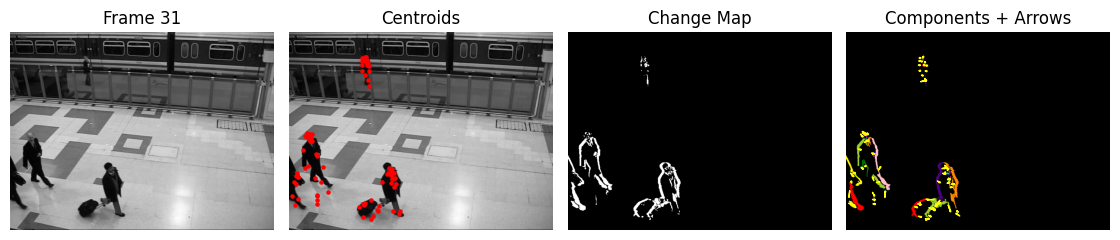

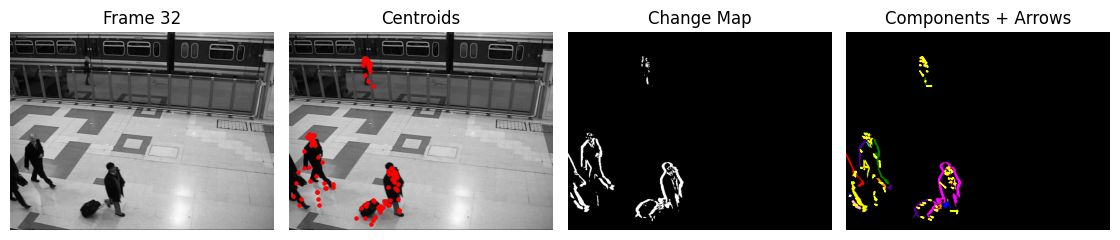

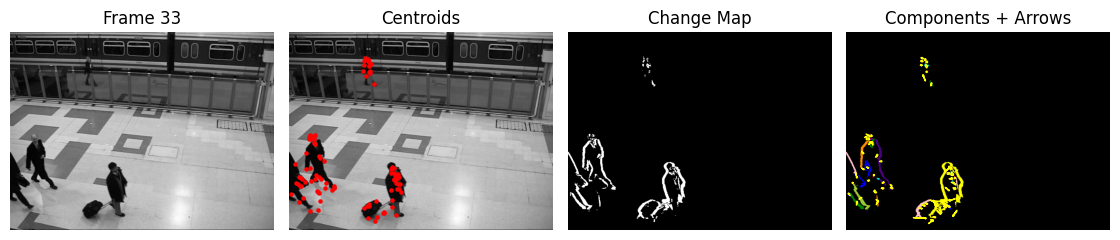

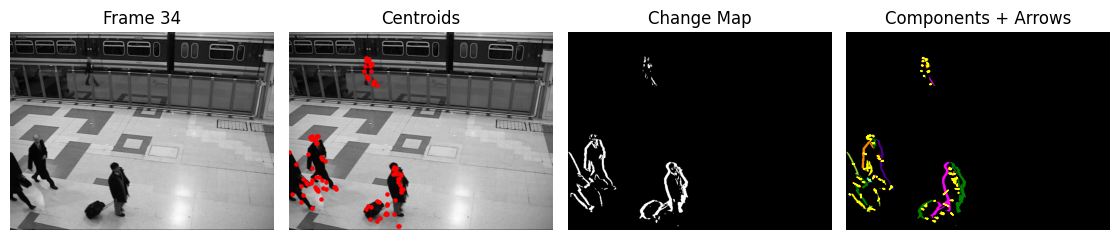

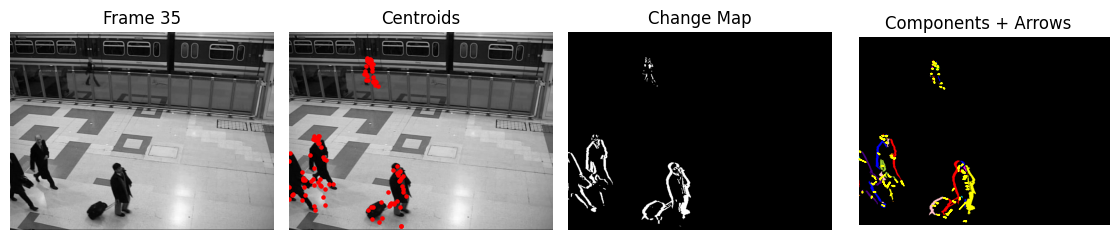

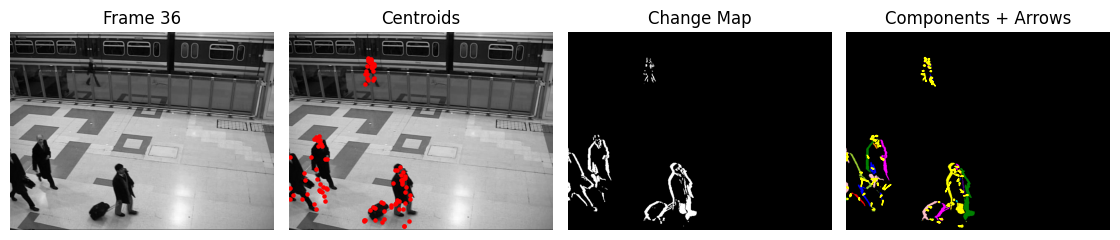

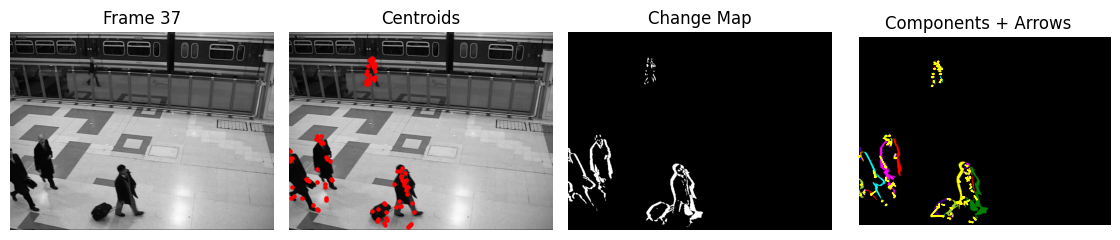

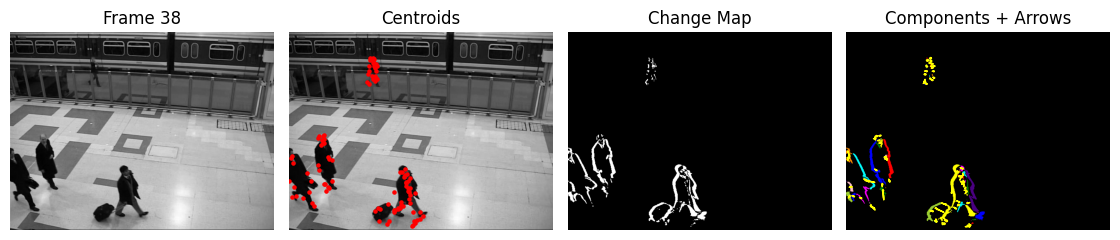

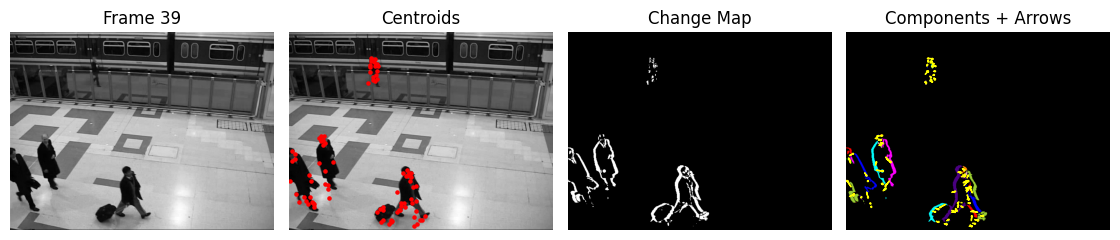

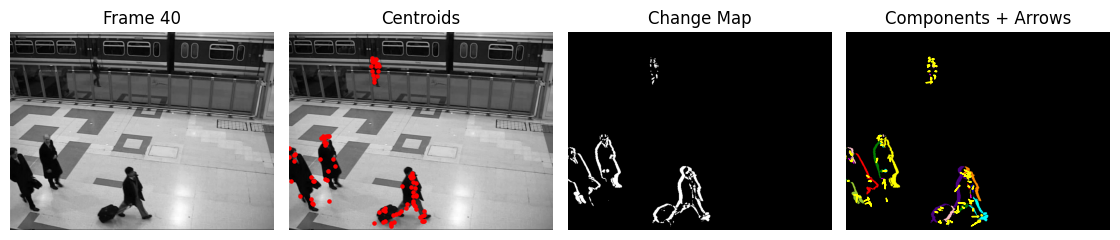

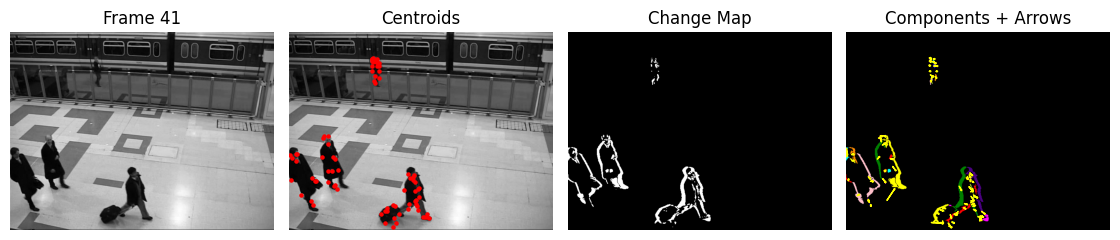

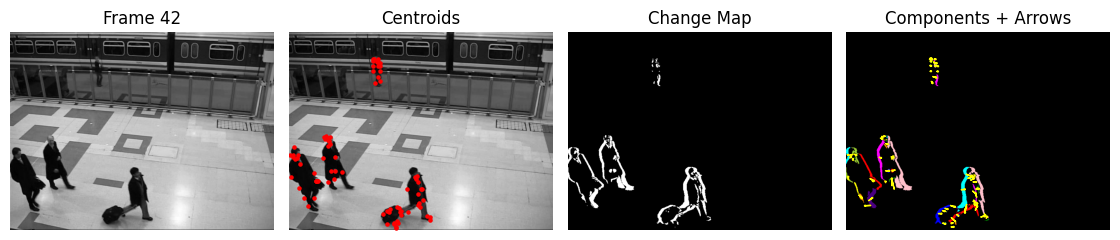

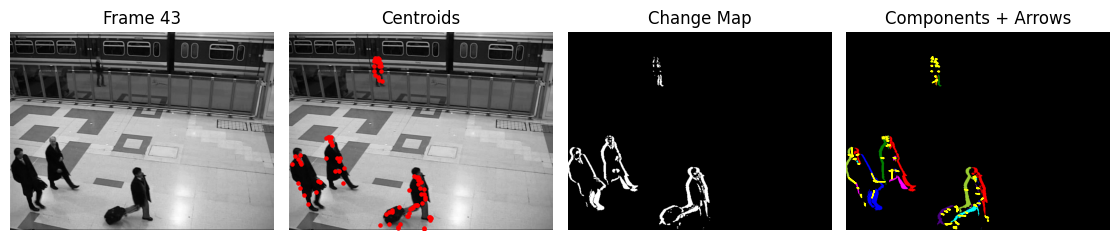

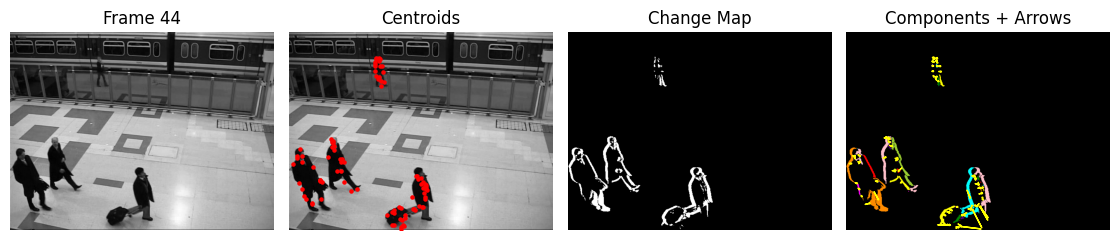

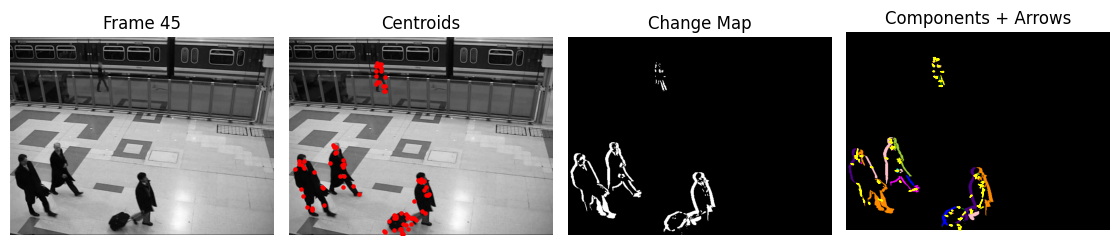

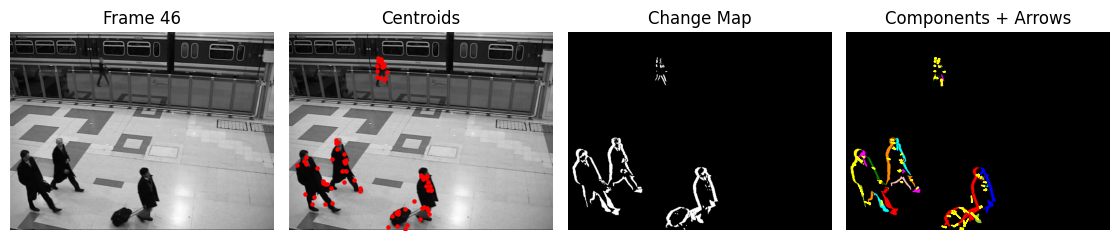

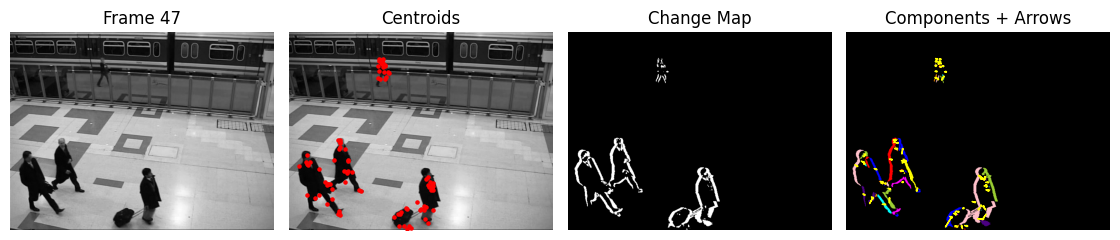

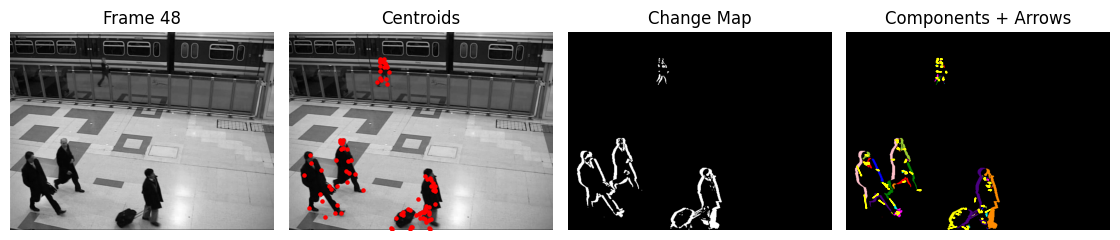

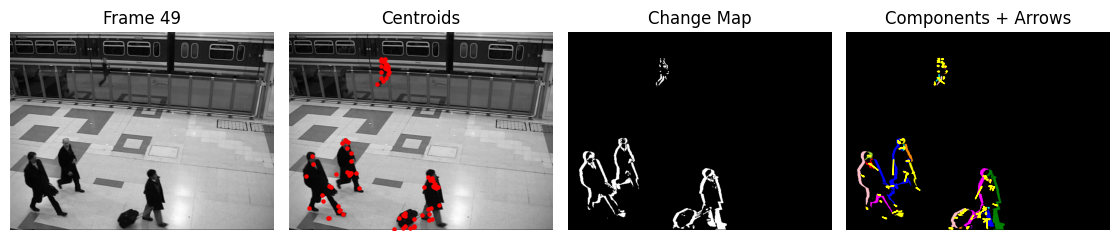

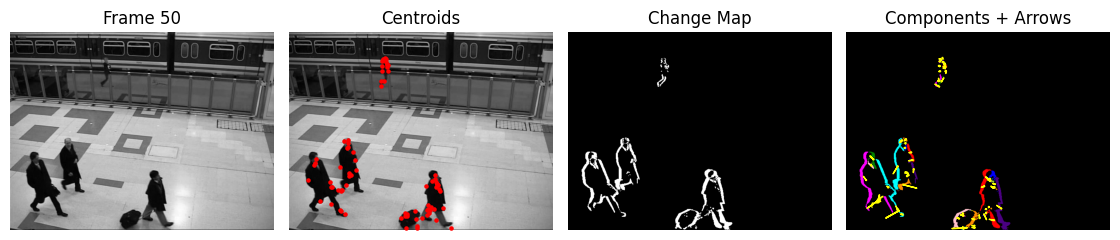

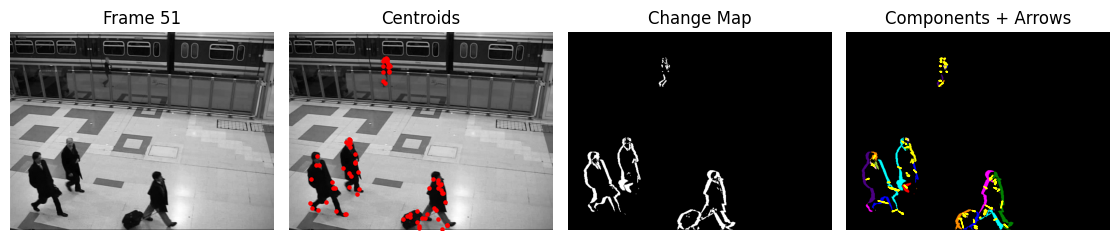

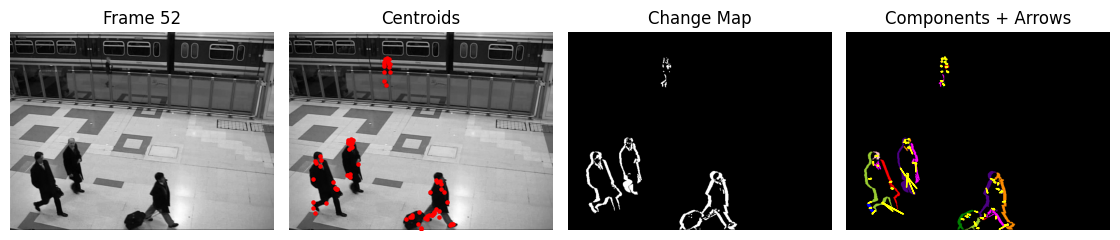

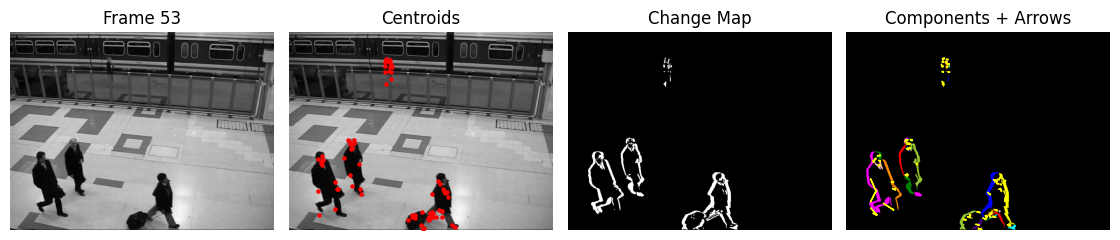

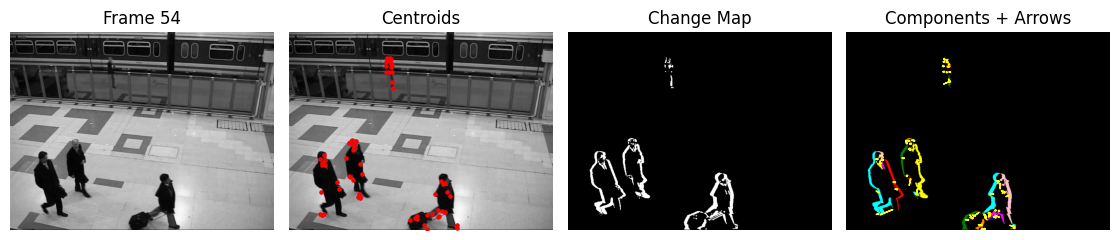

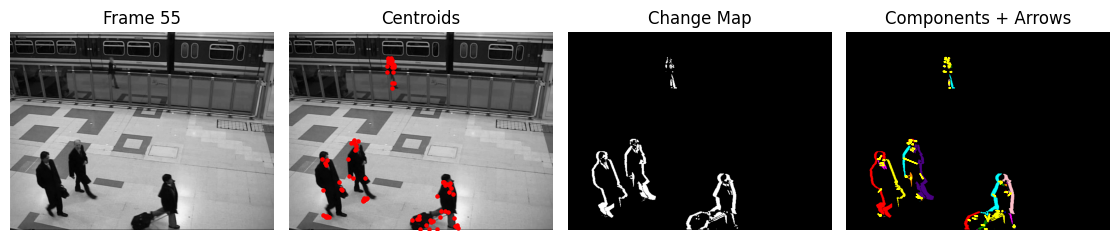

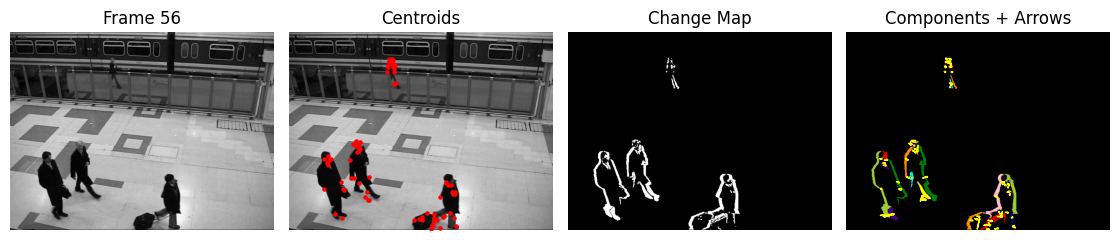

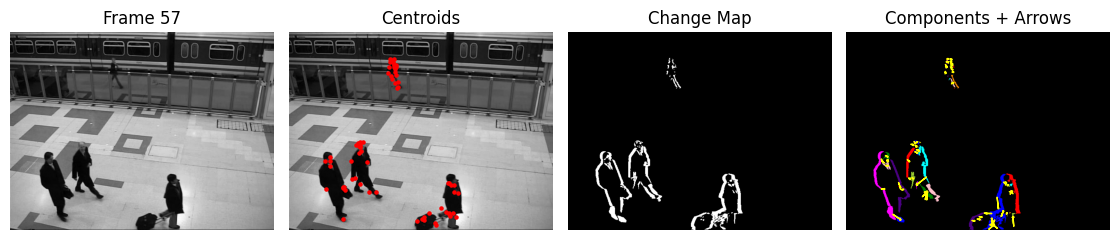

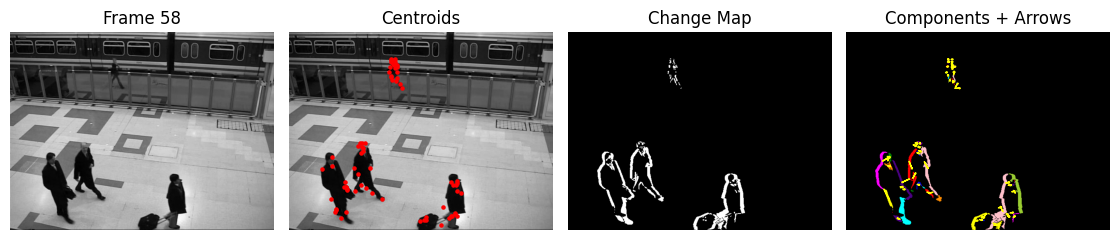

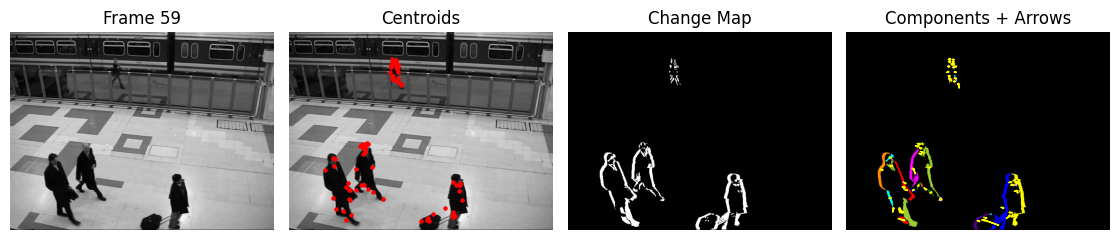

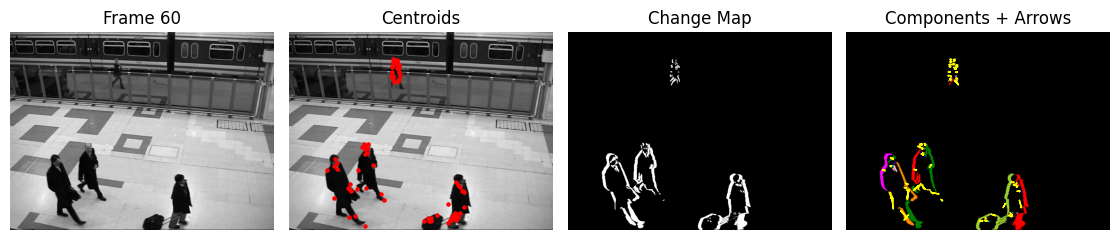

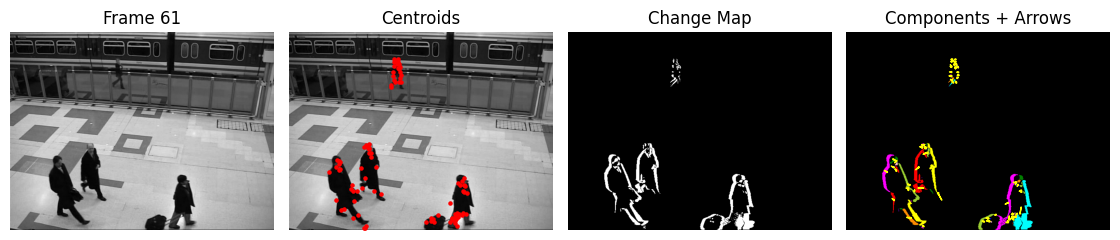

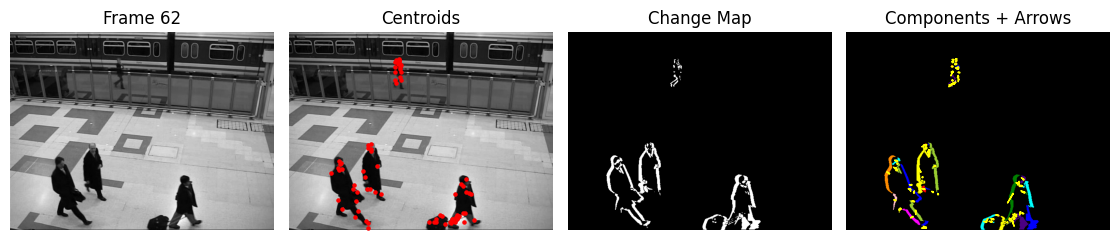

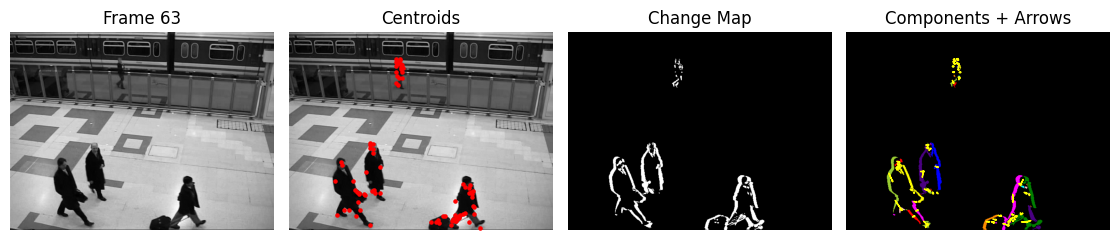

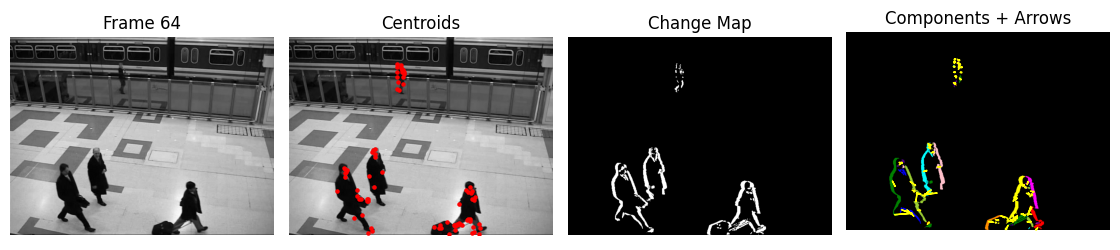

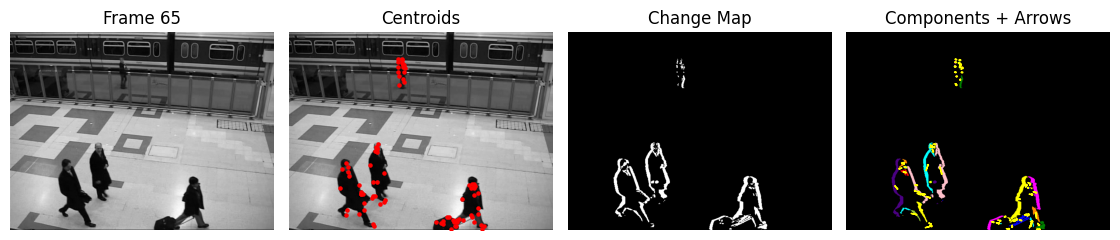

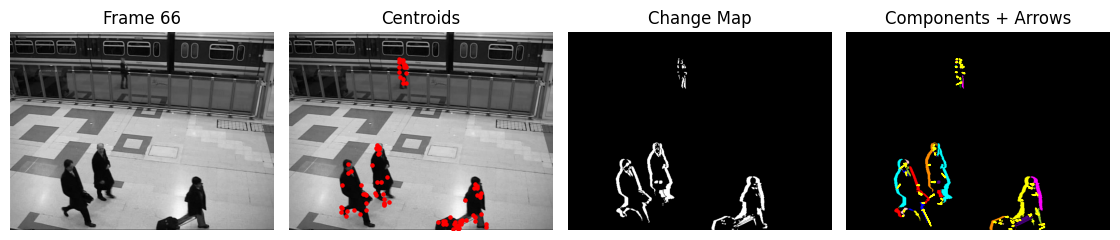

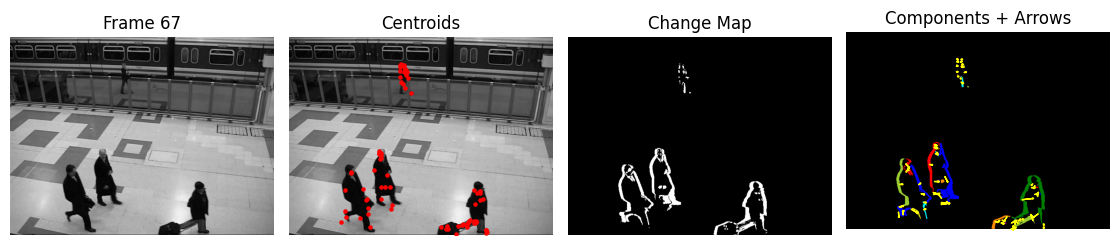

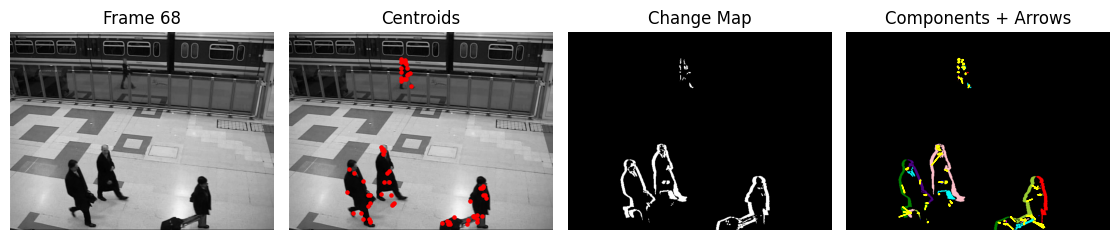

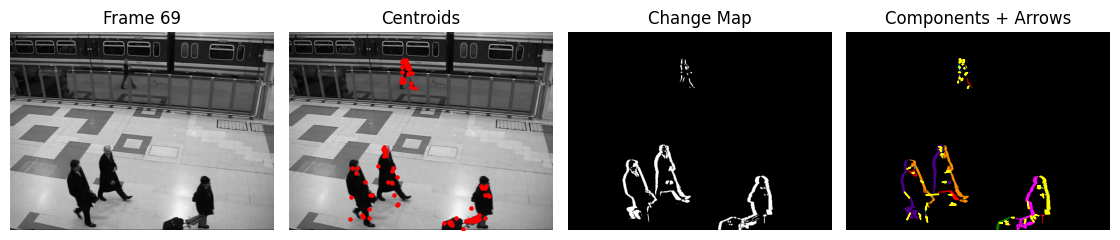

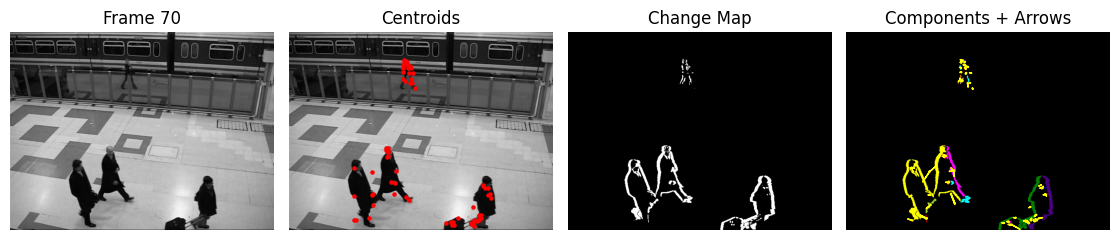

In [3]:
# --- Set parameters ---
threshold = 0.1
centroids_over_time = []

# --- Process frames ---
for i in range(len(frames) - 1):
    diff = np.abs(frames[i+1] - frames[i])
    binary = (diff > threshold).astype(np.uint8)

    labeled, num = label(binary)
    centroids = center_of_mass(binary, labeled, range(1, num + 1))
    centroids_over_time.append(centroids)

    colored = label2rgb(labeled, bg_label=0)

    fig, axs = plt.subplots(1, 4, figsize=(11.3, 3))

    axs[0].imshow(frames[i+1], cmap='gray')
    axs[0].set_title(f'Frame {i+1}')
    axs[0].axis('off')

    axs[1].imshow(frames[i+1], cmap='gray')
    axs[1].set_title('Centroids')
    axs[1].axis('off')

    if centroids:
        y, x = zip(*centroids)
        axs[1].scatter(x, y, c='red', s=5)

    axs[2].imshow(binary, cmap='gray')
    axs[2].set_title('Change Map')
    axs[2].axis('off')

    axs[3].imshow(colored)
    axs[3].set_title('Components + Arrows')
    axs[3].axis('off')

    if i > 0:
        prev_centroids = centroids_over_time[i - 1]
        for c0 in prev_centroids:
            distances = [np.linalg.norm(np.array(c1) - np.array(c0)) for c1 in centroids]
            if distances:
                min_idx = np.argmin(distances)
                c1 = centroids[min_idx]
                axs[3].arrow(c0[1], c0[0], c1[1] - c0[1], c1[0] - c0[0],
                             head_width=3, head_length=3, fc='yellow', ec='yellow')

    plt.tight_layout()
    plt.show()

##### **Change Detection and Binary Map Generation**


We start by loading a series of grayscale frames from images. To detect motion, we compute the absolute difference between each pair of consecutive frames and then apply a threshold to create a binary map that highlights areas where changes occurred.

On this binary map, we find **connected components**, which represent distinct moving objects. For each component, we calculate the centroid, which serves as the object's approximate position.

To visualize the tracking, we plot the current frame, the binary change map, and a colored map of connected components. We also mark the centroids on the frame and draw arrows linking centroids from the previous frame to the current ones, showing the estimated movement of each object.

Choosing the right threshold for change detection is crucial: too low and we get noise, too high and we miss small movements. We discuss parameter choices and their impact in the experiments section.


In [4]:
from scipy.spatial.distance import cdist

# List of trajectories: each trajectory is a list of (y, x) coordinates over time
trajectories = []

# Initialize trajectories with the centroids from the first frame
for c in centroids_over_time[0]:
    trajectories.append([c])

# Loop through the rest of the frames
for t in range(1, len(centroids_over_time)):
    # Get the last known positions (latest centroids) for all trajectories
    prev_centroids = np.array([traj[-1] for traj in trajectories])
    # Get the centroids detected in the current frame
    curr_centroids = np.array(centroids_over_time[t])

    if len(curr_centroids) == 0 or len(prev_centroids) == 0:
        # If there are no centroids in either the current or previous frame, skip this step
        continue

    # Compute the distance matrix between previous and current centroids
    dist_matrix = cdist(prev_centroids, curr_centroids)

    # Assign the closest current centroid to each trajectory
    assigned = set()  # Keep track of which centroids have already been assigned
    for i, dists in enumerate(dist_matrix):
        j = np.argmin(dists)  # Index of the closest centroid in the current frame
        if j not in assigned:
            # If the centroid hasn't been assigned yet, update the trajectory
            trajectories[i].append(tuple(curr_centroids[j]))
            assigned.add(j)
        else:
            # If the centroid is already assigned to another trajectory,
            # we assume this trajectory has lost track (e.g., occlusion or exit),
            # so we repeat the last known position
            trajectories[i].append(trajectories[i][-1])

##### **Object Trajectory Visualization**

- Trajectories on Initial Frame: The first plot shows all trajectories overlaid on the first frame, using unique colors for each path. This helps see the starting movements relative to the scene.

- Trajectories on a Later Frame: The second plot displays the trajectories on a subsequent frame (frame 70 in this case). This shows how the objects have moved and their positions later in the sequence, illustrating cumulative motion.

- Isolated Trajectories: The third plot shows only the colored trajectory lines without any background. This view highlights the paths' shape and spatial distribution across the image area, making overall motion patterns clearer.

Each trajectory connects the detected centroids of an object across frames. Distinct colors help identify and follow individual objects. The Y-axis is inverted to match standard image coordinates (origin at top-left).

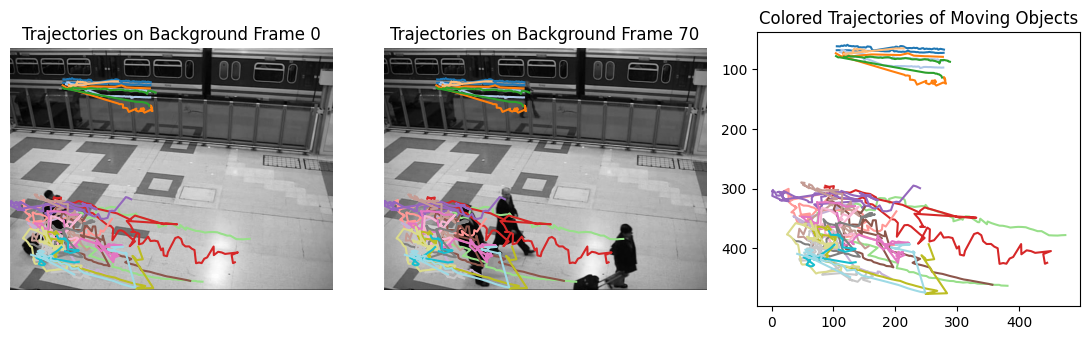

In [5]:
# Trajectories animation
colors = plt.get_cmap('tab20', len(trajectories))

fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))

background = frames[0]
axs[0].imshow(background, cmap='gray')
for i, traj in enumerate(trajectories):
    traj = np.array(traj)
    axs[0].plot(traj[:, 1], traj[:, 0], color=colors(i), label=f'Traj {i}')
axs[0].set_title('Trajectories on Background Frame 0')
axs[0].axis('off')

background = frames[70]
axs[1].imshow(background, cmap='gray')
for i, traj in enumerate(trajectories):
    traj = np.array(traj)
    axs[1].plot(traj[:, 1], traj[:, 0], color=colors(i), label=f'Traj {i}')
axs[1].set_title('Trajectories on Background Frame 70')
axs[1].axis('off')

for i, traj in enumerate(trajectories):
    traj = np.array(traj)
    axs[2].plot(traj[:, 1], traj[:, 0], color=colors(i), label=f'Traj {i}')
axs[2].invert_yaxis()
axs[2].set_title('Colored Trajectories of Moving Objects')

plt.tight_layout()
plt.show()

##### **Kalman Filtering**

The filter works for each frame:

It predicts the object's next position based on its current estimated position, velocity, and a motion model (assuming constant velocity here).

If a new detected centroid is found close to the predicted position, the filter uses it to update its estimate, combining the prediction and measurement for a more accurate result. If no close centroid is found, the filter relies on its prediction alone.

This process smooths the raw centroid positions, reducing noise and making the trajectories more stable, even if some detections are inaccurate or missing. The filtered positions are saved to create the improved trajectories

In [6]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=052e936ec1f9ddcb9a5fca479008d9b6021729a7543dc42694f9cf356a7aa200
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [7]:
from filterpy.kalman import KalmanFilter

def create_kalman():
    # Create a Kalman Filter with:
    # - 4 state variables: [x, y, vx, vy]
    # - 2 measurement variables: [x, y]
    kf = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0  # Time interval between frames

    # State transition matrix (how the state evolves over time)
    kf.F = np.array([[1, 0, dt, 0],
                     [0, 1, 0, dt],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

    # Observation matrix (we can observe only positions: x and y)
    kf.H = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0]])

    # Initial covariance matrix: start with high uncertainty
    kf.P *= 1000.

    # Measurement noise (how noisy we expect the centroid measurements to be)
    kf.R = np.eye(2) * 5

    # Process noise (uncertainty in the model's motion prediction)
    kf.Q = np.eye(4) * 0.01

    return kf

# Initialize a Kalman filter for each detected trajectory
kalman_filters = [create_kalman() for _ in trajectories]

# Initialize each filter's state with the first observed position (x, y), and zero velocity
for kf, traj in zip(kalman_filters, trajectories):
    x, y = traj[0]
    kf.x = np.array([x, y, 0, 0])  # [position_x, position_y, velocity_x, velocity_y]

# Prepare a list to store the filtered (smoothed) trajectories
filtered_trajectories = [[] for _ in trajectories]

# Loop through each frame to update the Kalman filters
for t in range(len(centroids_over_time)):
    curr_centroids = np.array(centroids_over_time[t]) if t < len(centroids_over_time) else np.array([])

    for i, kf in enumerate(kalman_filters):
        # Predict the next state
        kf.predict()

        if len(curr_centroids) > 0:
            # Compute distances between the prediction and the current centroids
            dists = np.linalg.norm(curr_centroids - kf.x[:2], axis=1)
            idx_min = np.argmin(dists)

            if dists[idx_min] < 20:  # If the closest centroid is within a reasonable distance
                z = curr_centroids[idx_min]
                kf.update(z)  # Update the filter with the observed position

        # Save the filtered position estimate
        filtered_trajectories[i].append((kf.x[0], kf.x[1]))

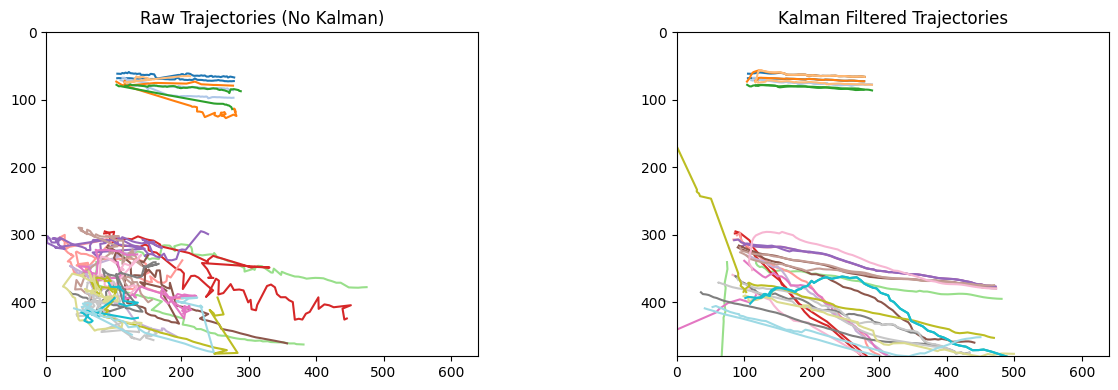

In [8]:
height, width = frames[0].shape

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

for i, traj in enumerate(trajectories):
    traj = np.array(traj)
    axs[0].plot(traj[:, 1], traj[:, 0], color=colors(i))
axs[0].set_title('Raw Trajectories (No Kalman)')

for i, traj in enumerate(filtered_trajectories):
    traj = np.array(traj)
    axs[1].plot(traj[:, 1], traj[:, 0], color=colors(i))
axs[1].set_title('Kalman Filtered Trajectories')

for ax in axs:
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()